In [1]:
import numpy as np 
import pandas as pd 
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
diabetes_df = pd.read_csv("/kaggle/input/diabetes-data-set/diabetes.csv")
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Coin Toss

**QUERY**: *How many girls are diabetic?*

The first thing we do is to implement the coin toss mechanism. Starting from a binary vector for all element we flip a coin. If we obtain head we give in output the same value as input. But if we obtain tail, the output is random: we flip another coin and with head we return one, otherwise zero.

In our dataset the best column to check this method is the outcome. So we pass all value to the coin toss method. After that we check the probability. In the original dataset the probabilty of 1 is 0.349; in the perturbed dataset we obatin 0.346.


After that we implement the epsilon coin toss. The principal difference is that in this case we flip the binary value according to epsilon. 

In [3]:
def coinToss(data):
    size = len(data)
    outputs = []
    for i in range(size):
        if random.randint(0,1) == 0:
            outputs.append(data[i])
        else:
            outputs.append(1 if random.randint(0,1) == 0 else 0)

    return outputs

In [4]:
def getOriginalProbabilities(data):
    Y = np.sum(data)/len(data)
    p = 2*Y - 1/2
    return p

In [5]:
outcome = diabetes_df["Outcome"]
data_after_coin_toss = coinToss(outcome)
print(f"Percent number of 1 in original coloum: {outcome.sum()/len(outcome):.3f}")
print(f"Percent number of 1 after coin toss: {getOriginalProbabilities(data_after_coin_toss):.3f}")

Percent number of 1 in original coloum: 0.349
Percent number of 1 after coin toss: 0.396


In [6]:
def verifyCointoss(trueAnswers, cointoss):
    #probability of simulated yes where the true answer was yes
    prx = len(np.where((np.array(cointoss)==1) & (np.array(trueAnswers)==1))[0])/len(np.where(np.array(trueAnswers)==1)[0])
    # probaility of sumulated yes where thee true answer was no
    pry = len(np.where((np.array(cointoss)==1) & (np.array(trueAnswers)==0))[0])/len(np.where(np.array(trueAnswers)==0)[0])

    return prx/pry

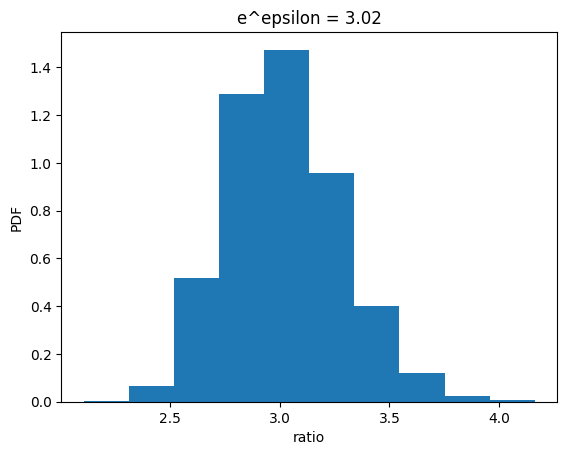

In [7]:
simsize = 10000
probabilities = []
for s in range(simsize):
    probabilities.append(verifyCointoss(outcome, coinToss(outcome)))
                         
plt.hist(probabilities, density=True)
plt.ylabel("PDF")
plt.xlabel("ratio")
plt.title(f"e^epsilon = {np.mean(probabilities):.2f}")
plt.show()

In [8]:
def epsilonCointoss(data, epsilon=1e-5):
    size = len(data)
    outputs = []
    
    p_1_given_1 = np.exp(epsilon) / (np.exp(epsilon) + 1)
        
    for x in data:
        if np.random.random() < p_1_given_1:
            outputs.append(x)
        else:
            outputs.append(1 if x == 0 else 0)
        
    return outputs

In [9]:
def getEpsilonOriginalProbabilities(data, epsilon):
    Y = np.sum(data)/len(data)
    e_eps = np.exp(epsilon)
    
    numerator = Y * (e_eps + 1) - 1
    denominator = e_eps - 1
    
    p = numerator / denominator
    return p

In [10]:
p0 = np.sum(outcome)/len(outcome)
epsilon = 1
print(f"epsilon: {epsilon}")
data = outcome
tct = epsilonCointoss(data, epsilon)
print(f"original p:{p0} - observed {getEpsilonOriginalProbabilities(tct, epsilon):.5f}")

epsilon: 1
original p:0.3489583333333333 - observed 0.37884


Real Probability: 0.34896


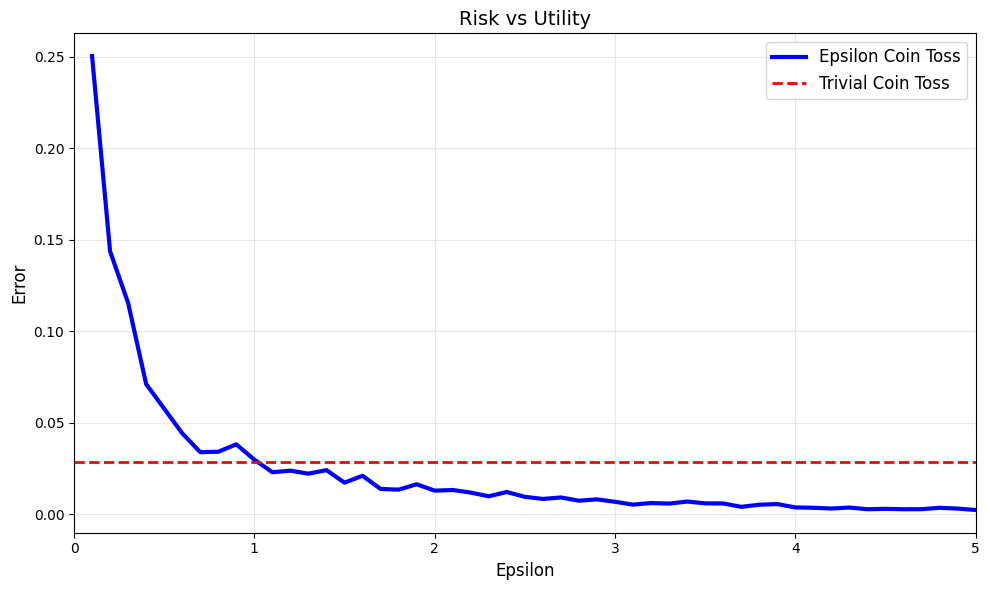

In [47]:
outcome = diabetes_df['Outcome'].values

true_prob = np.sum(outcome)/len(outcome)
print(f"Real Probability: {true_prob:.5f}")

eps_values = np.linspace(0.1, 5.0, 50)
eps_errors = []

# Epsilon
for eps in eps_values:
    sim_errors = []
    for _ in range(20):
        noisy = epsilonCointoss(outcome, eps)
        est = getEpsilonOriginalProbabilities(noisy, eps)
        sim_errors.append(abs(est - true_prob))
    eps_errors.append(np.mean(sim_errors))

# Trivial
std_sim_errors = []
for _ in range(50):
    noisy = coinToss(outcome)
    est = getOriginalProbabilities(noisy)
    std_sim_errors.append(abs(est - true_prob))
std_error_fixed = np.mean(std_sim_errors)

plt.figure(figsize=(10, 6))
plt.plot(eps_values, eps_errors, 
         color='blue', linewidth=3, label='Epsilon Coin Toss')

plt.axhline(y=std_error_fixed, color='red', linestyle='--', linewidth=2, label='Trivial Coin Toss')

plt.title("Risk vs Utility", fontsize=14)
plt.xlabel("Epsilon", fontsize=12)
plt.ylabel("Error", fontsize=12)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xlim(0, 5)

plt.tight_layout()
plt.show()

# Laplace Mechanism

**QUERY**: *How many pregnancies have the girls?*

For the Laplace Mechanism we use the pregnancies column. 

Our counting query is: "how many girls have got n pregnancies?". Starting from this question we build a histogram and give it to the Laplace method. We can check the difference between the two graph: the first doesn't have any noisy, meanwhile the second has a little.

After, we set some epsilon and delta value and for all of it we compute the theoretical bound and check if it is consistent based on some simulation.

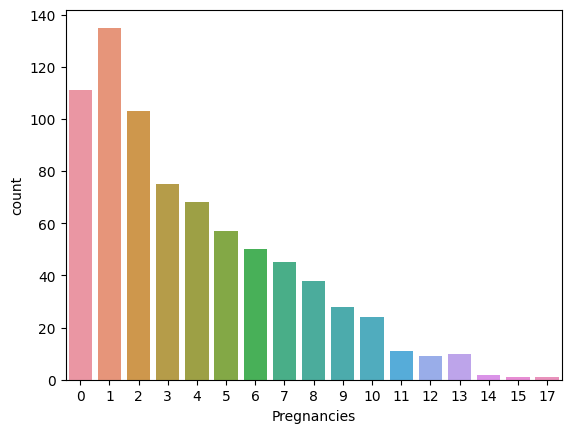

In [12]:
n_pregnancies = diabetes_df["Pregnancies"]

sns.countplot(x=n_pregnancies)
plt.show()

In [13]:
def laplace_mechanism(original_values, epsilon=1e-5, sensitivity=1):
    outputs = original_values + np.random.laplace(scale = sensitivity/epsilon, loc=0, size=len(original_values))
    return outputs

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


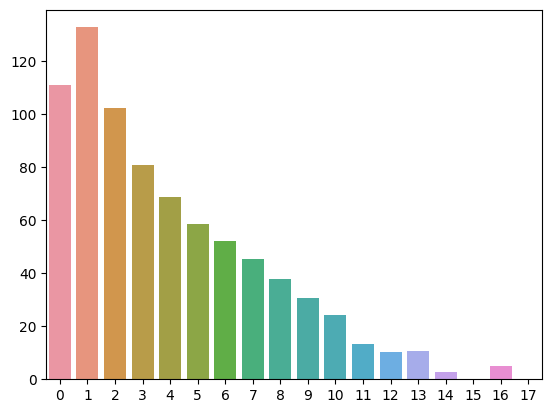

In [14]:
epsilon = 0.5

outputs = []
categories = range(0, n_pregnancies.max() + 1)

for x in categories:
    real_count = len(np.where(n_pregnancies == x)[0])
    noisy_val = laplace_mechanism([real_count], epsilon)[0] 
    outputs.append(noisy_val)

outputs = np.maximum(outputs, 0)
sns.barplot(x=list(categories), y=outputs)
plt.show()

In [15]:
import numpy as np

values, histogram = np.unique(n_pregnancies, return_counts=True)

sensitivity = 1
query_dimension = len(histogram)
exp_samples = 10000

epsilons = [0.01, 0.1, 0.5, 1, 10]
deltas = [1e-3, 0.01, 0.1]

results = []

for epsilon in epsilons:
    for delta in deltas:
        
        ratio = np.log(query_dimension / delta) * (sensitivity / epsilon)
        
        errors = []
        for _ in range(exp_samples):
            perturbed = laplace_mechanism(
                histogram,
                epsilon=epsilon,
                sensitivity=sensitivity
            )
            
            max_error = np.max(np.abs(perturbed - histogram))
            errors.append(max_error >= ratio)

        empirical_prob = np.mean(errors)

        results.append({
            "epsilon": epsilon,
            "delta": delta,
            "ratio": ratio,
            "empirical_prob": empirical_prob
        })

for r in results:
    print(
        f"(epsilon={r['epsilon']:>5}) - probability of having an error bigger than {r['ratio']:.3f}: {r['empirical_prob']:.6f} -- expected <= {r['delta']:<8}"
    )


(epsilon= 0.01) - probability of having an error bigger than 974.097: 0.001000 -- expected <= 0.001   
(epsilon= 0.01) - probability of having an error bigger than 743.838: 0.010400 -- expected <= 0.01    
(epsilon= 0.01) - probability of having an error bigger than 513.580: 0.096200 -- expected <= 0.1     
(epsilon=  0.1) - probability of having an error bigger than 97.410: 0.000800 -- expected <= 0.001   
(epsilon=  0.1) - probability of having an error bigger than 74.384: 0.010400 -- expected <= 0.01    
(epsilon=  0.1) - probability of having an error bigger than 51.358: 0.089700 -- expected <= 0.1     
(epsilon=  0.5) - probability of having an error bigger than 19.482: 0.001400 -- expected <= 0.001   
(epsilon=  0.5) - probability of having an error bigger than 14.877: 0.009200 -- expected <= 0.01    
(epsilon=  0.5) - probability of having an error bigger than 10.272: 0.097400 -- expected <= 0.1     
(epsilon=    1) - probability of having an error bigger than 9.741: 0.001400 --

# Exponential Mechanism

**QUERY**: *We want to divide the people in two group with the same size based on the age.*

In [16]:
age = diabetes_df["Age"].values

# considero come età possibili tutte quella da 19 a 80 comprese
R_size = 81
R = list(range(18, R_size))

In [17]:
def utility_function(R, data):
    data = data
    utilities = []
    for r in R:
        group1 = data[data <= r]
        group2 = data[data > r]

        error = abs(len(group1) - len(group2))
        utilities.append(-error)

    return utilities

In [18]:
real_utility = utility_function(R, age)
print(real_utility)

[-768, -768, -768, -642, -498, -422, -330, -234, -168, -104, -34, -24, -66, -114, -146, -180, -208, -228, -260, -298, -330, -354, -380, -424, -460, -486, -502, -532, -558, -570, -580, -590, -606, -622, -638, -648, -660, -668, -674, -684, -698, -704, -714, -718, -726, -734, -736, -742, -750, -756, -758, -762, -764, -764, -766, -766, -766, -766, -766, -766, -766, -766, -766]


In [19]:
perturbed_utils = []
for i in range(len(age)):
    new_age = np.concatenate((age[:i], age[i+1:]))
    perturbed_utils.append(utility_function(R, new_age))

perturbed_utils.append(utility_function(R, np.concatenate(([70], age))))

sensitivity = np.max([
    np.max(np.abs(np.array(real_utility) - np.array(pu))) 
    for pu in perturbed_utils
])
print(sensitivity)

1


In [20]:
def exponential_mechanism(R, true_utility, sensitivity, epsilon=0.5):
    true_utility = np.array(true_utility)

    probabilities = np.exp(true_utility*(epsilon/(2*sensitivity)))
    probabilities /= np.sum(probabilities)
    output = np.random.choice(R, p=probabilities)
    
    return output, probabilities

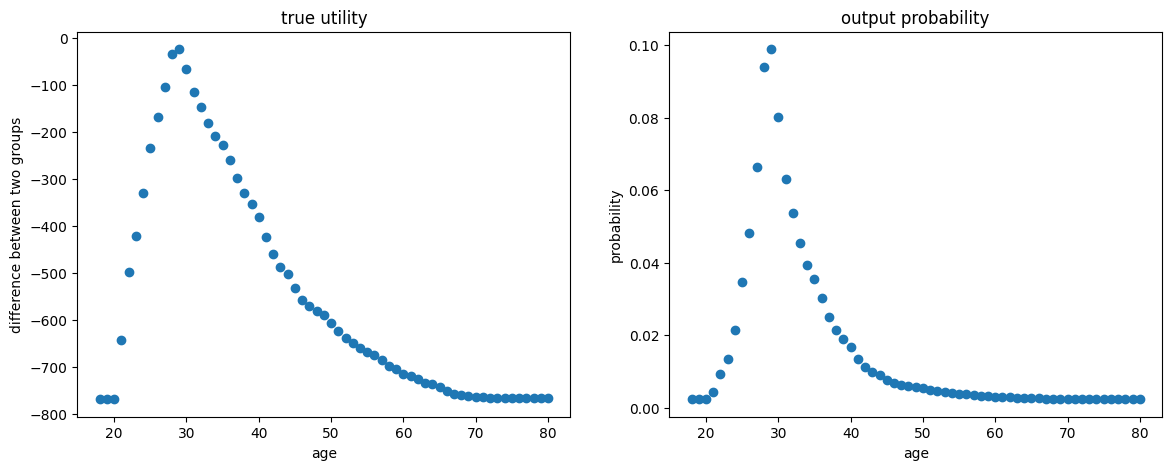

best age: 29 - optimal utility: -24.00
output value: 26.00 - revenue: -168.00


In [21]:
epsilon = 0.01

sampled_price, probabilities = exponential_mechanism(R, real_utility, sensitivity, epsilon)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.set(title = "true utility", xlabel = "age", ylabel = "difference between two groups")
ax1.scatter(R, real_utility)

ax2.set(title = "output probability", xlabel = "age", ylabel = "probability")
ax2.scatter(R, probabilities)
plt.show()

revenue = utility_function([sampled_price], age)[0]
optimal_revenue = real_utility[np.argmax(real_utility)]
print(f"best age: {R[np.argmax(real_utility)]} - optimal utility: {optimal_revenue:.2f}")
print(f"output value: {sampled_price:.2f} - revenue: {revenue:.2f}");

# Sparse Vector

**QUERY**: *How is the Glucose value of the girls?*

In [22]:
glucose = diabetes_df["Glucose"].values
epsilons = [0.001, 0.01, 0.1, 0.25, 0.5, 1.0, 10.0]
threshold = 195

In [23]:
def sparse_vectors(data, queries, threshold, epsilon):
    results = {}

    for eps in epsilons:
        threshold_perturbed = np.random.laplace(threshold, 2/eps)
        run_output = []

        for q in queries:
            qnoise = np.random.laplace(0, 4/eps)
            noisy_value = q(data) + qnoise

            if noisy_value >= threshold_perturbed:
                run_output.append("ABOVE")
                break
            else:
                run_output.append("BELOW")

        results[eps] = run_output

    return results

In [24]:
queries = [lambda x, i=i: x[i] for i in range(len(glucose))]

output = sparse_vectors(glucose, queries, threshold, epsilon)

for eps, result in output.items():
    print(f"epsilon = {eps}, output = {result}")

epsilon = 0.001, output = ['ABOVE']
epsilon = 0.01, output = ['ABOVE']
epsilon = 0.1, output = ['ABOVE']
epsilon = 0.25, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE']
epsilon = 0.5, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE']
epsilon = 1.0, output = ['BELOW', 'BELOW', 'ABOVE']
epsilon = 10.0, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE']


In [25]:
def sparse(data, queries, threshold, epsilon, limit_c):
    results = {}
    
    for eps in epsilons:
        count = 0
        threshold_perturbed = np.random.laplace(threshold, 2/eps)
        run_output = []

        for q in queries:
            qnoise = np.random.laplace(0, 4/eps)
            noisy_value = q(data) + qnoise

            if noisy_value >= threshold_perturbed:
                run_output.append("ABOVE")
                count += 1
                if count == limit_c:
                    break
            else:
                run_output.append("BELOW")

        results[eps] = run_output

    return results

In [26]:
limit_c = 3
queries = [lambda x, i=i: x[i] for i in range(len(glucose))]

output = sparse(glucose, queries, threshold, epsilon, limit_c)

for eps, result in output.items():
    print(f"epsilon = {eps}, output = {result}")

epsilon = 0.001, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE', 'BELOW', 'ABOVE', 'BELOW', 'ABOVE']
epsilon = 0.01, output = ['BELOW', 'ABOVE', 'BELOW', 'ABOVE', 'ABOVE']
epsilon = 0.1, output = ['ABOVE', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE', 'ABOVE']
epsilon = 0.25, output = ['BELOW', 'BELOW', 'ABOVE', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'ABOVE']
epsilon = 0.5, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW'

In [27]:
def numeric_sparse(data, queries, threshold, epsilon, limit_c):
    results = {}
    
    for eps in epsilons:
        count = 0
        threshold_perturbed = np.random.laplace(threshold, 2/eps)
        run_output = []

        for q in queries:
            qnoise = np.random.laplace(0, 4/eps)
            noisy_value = q(data) + qnoise

            if noisy_value >= threshold_perturbed:
                run_output.append(("ABOVE", noisy_value))
                count += 1
                if count == limit_c:
                    break
            else:
                run_output.append("BELOW")

        results[eps] = run_output

    return results

In [28]:
limit_c = 3
queries = [lambda x, i=i: x[i] for i in range(len(glucose))]

output = numeric_sparse(glucose, queries, threshold, epsilon, limit_c)

for eps, result in output.items():
    print(f"epsilon = {eps}, output = {result}")

epsilon = 0.001, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', ('ABOVE', 1501.0091032006012), 'BELOW', ('ABOVE', 11136.878415331075), 'BELOW', 'BELOW', ('ABOVE', 1877.8091431974663)]
epsilon = 0.01, output = [('ABOVE', 304.2157956871208), ('ABOVE', 1123.750361415275), 'BELOW', 'BELOW', ('ABOVE', 710.5834517131447)]
epsilon = 0.1, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', ('ABOVE', 335.36441286034733), 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', ('ABOVE', 249.42554192050997), 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', ('ABOVE', 243.96587246535466)]
epsilon = 0.25, output = ['BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', 'BELOW', ('ABOVE', 183.3568693493642), 'BELOW', ('ABOVE', 202.41198164311209), ('ABOVE', 218.78440697086177)]
epsilon = 0.5, output = ['BELOW', 'BELOW', 'BELOW',

# Mean Query

**QUERY**: *What is the average age of girls?*

In [29]:
def clip (v, l, u):
    if v>u:
        return u
    elif v<l:
        return l
    else:
        return v
    
def clipped_sum(data, lower, upper):
    return np.array([clip(v, lower, upper) for v in data]).sum()

In [30]:
def above_threshold(queries, df, T, epsilon):
    T_hat = T + np.random.laplace(loc=0, scale = 2/epsilon)   
    for idx, q in enumerate(queries):
        nu_i = np.random.laplace(loc=0, scale = 4/epsilon)
        if q(df) + nu_i >= T_hat:
            return idx
  
    return random.randint(0,len(queries)-1)

In [31]:
def auto_avg(df, epsilon):
    def create_query(b):
        return lambda df: clipped_sum(df, 0, b) - clipped_sum(df, 0, b+1)

    bs = range(1,150000,5)
    queries = [create_query(b) for b in bs]
    
    epsilon_svt = epsilon / 3
    final_b = bs[above_threshold(queries, df, 0, epsilon_svt)]
    
    epsilon_sum = epsilon / 3
    epsilon_count = epsilon / 3
    
    noisy_sum = np.random.laplace(loc=clipped_sum(df, 0, final_b), scale=final_b/epsilon_sum)
    noisy_count = np.random.laplace(loc=len(df), scale=1/epsilon_count)
    
    return noisy_sum/noisy_count

In [32]:
print(f"real mean: {np.mean(age)} - dp mean: {auto_avg(age, 0.1)}")

real mean: 33.240885416666664 - dp mean: 30.831272326082438


# RAPPOR

In [33]:
p = 0.2
q = 0.8
f = 0.5

In [34]:
def Generalization(bins ,labels, target, df):    
    finisher = target+"_group"
        
    df[finisher] = pd.cut(df[target], bins=bins, labels=labels)
    df = df.drop(target, axis=1)
    
    sns.histplot(data=df, x=finisher)
    plt.show()
    
    return df

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


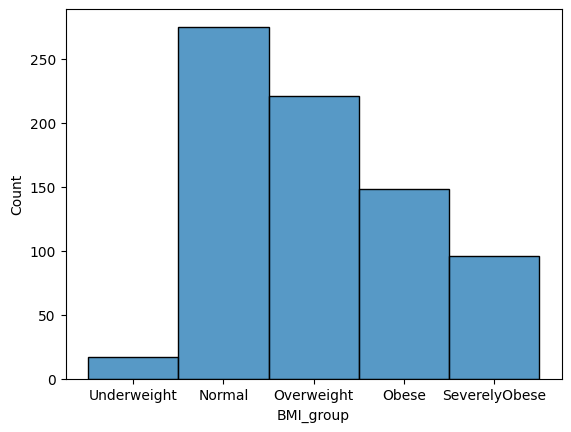

0         Overweight
1             Normal
2             Normal
3             Normal
4      SeverelyObese
           ...      
752       Overweight
753            Obese
754           Normal
755       Overweight
756       Overweight
Name: BMI_group, Length: 757, dtype: category
Categories (5, object): ['Underweight' < 'Normal' < 'Overweight' < 'Obese' < 'SeverelyObese']


In [35]:
bins = [0, 20.5, 30, 35, 40, 100]
labels = ['Underweight','Normal','Overweight','Obese','SeverelyObese']
BMI = Generalization(bins, labels, "BMI", diabetes_df)["BMI_group"]
BMI.dropna(inplace=True)
BMI = BMI.reset_index(drop=True)
print(BMI)

In [36]:
def hash_function_for_BMI(category_name):
    mapp = {
        "Underweight"  : 0,
        "Normal" : 1,
        "Overweight"   : 2,
        "Obese" : 3,
        "SeverelyObese": 4,
    }
    return mapp[category_name]

In [37]:
def BloomFiltering(category_name, K=5):
    idx = hash_function_for_BMI(category_name)
    B = [0] * K
    B[idx] = 1 
    return B

In [38]:
def coinTossRappor(data, f):
    size = len(data)
    outputs = []
    for i in range(size):
        if random.random() < 1 - f:
            outputs.append(data[i])
        else:
            outputs.append(1 if random.random() > 0.5 else 0)

    return outputs

In [39]:
def randomizeRespondeRappor(B_prime, q, p):
    i = 0
    report_response = []
    for i, bit in enumerate(B_prime):
        if bit == 1:
            report_response.append(1 if random.random() < q else 0)
        else: 
            report_response.append(1 if random.random() < p else 0)
    return report_response

In [40]:
def decode_rappor(reports, f, q, p):
    N_j = len(reports)
    c_ij = np.sum(reports, axis=0)
    
    num = p + 0.5 * f * q - 0.5 * f * p
    den = (1 - f) * (q - p)
    
    est = (c_ij - (num * N_j)) / (den)

    est = np.maximum(est, 0)
    return est

In [41]:
def compute_rappor_epsilon(h, f):
    return 2 * h * np.log10((1-0.5*f) / (0.5*f))

In [42]:
report = []

for i in range(len(BMI)):
    B = []
    B_prime = []
    B = BloomFiltering(BMI[i], 5)
    B_prime = coinTossRappor(B, f)
    report.append(randomizeRespondeRappor(B_prime, q, p))
    #print("---------")
    #print(f"index report {i} ")
    #print(f"{reportList[i]}")
    #print("---------")

estimated = decode_rappor(report, f, q, p)

In [43]:
print(f"RAPPOR is (proven to be) epsilon-DP, with epsilon={compute_rappor_epsilon(1,f):.5f}")

RAPPOR is (proven to be) epsilon-DP, with epsilon=0.95424


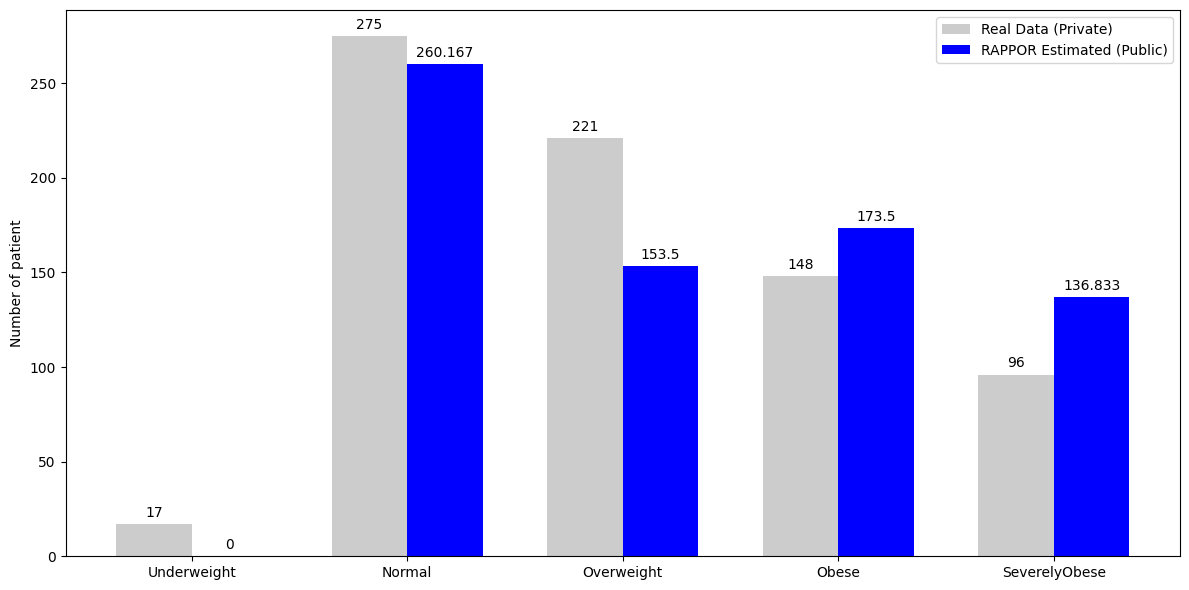

In [44]:
BMI_counts = BMI.value_counts().reindex(labels, fill_value=0)

labels = ['Underweight','Normal','Overweight','Obese','SeverelyObese']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))

# Barre Grigie (Verità Nascosta)
rects1 = ax.bar(x - width/2, BMI_counts, width, label='Real Data (Private)', color='gray', alpha=0.4)

# Barre Blu (Stima Pubblica RAPPOR)
rects2 = ax.bar(x + width/2, estimated, width, label='RAPPOR Estimated (Public)', color='blue')

ax.set_ylabel('Number of patient')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Aggiunge le etichette sopra le barre
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.tight_layout()
plt.show()